<a href="https://colab.research.google.com/github/BhardwajArjit/Causality-Informed-Segmentation/blob/main/Cityscapes_Segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Get setup

In [5]:
!pip install einops

import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth
from torchvision import datasets, transforms

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


## 1. Get data

In [6]:
!pip install opendatasets
import opendatasets as od
# downloading dataset from kaggle
od.download("https://www.kaggle.com/datasets/arjitdsce/cityscapes")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arjitdsce
Your Kaggle Key: ··········


100%|██████████| 103M/103M [00:01<00:00, 79.0MB/s] 


## 2. Data exploration and preparation

In [7]:
train_images_dir = "/content/cityscapes/cityscapes_data/train/images"
train_masks_dir = "/content/cityscapes/cityscapes_data/train/masks"

val_images_dir = "/content/cityscapes/cityscapes_data/val/images"
val_masks_dir = "/content/cityscapes/cityscapes_data/val/masks"

Image height: 256
Image width: 256


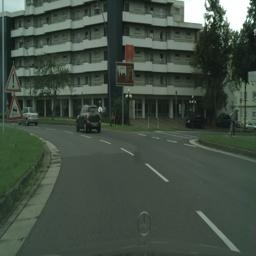

In [8]:
import random
from PIL import Image

# display the image
img = Image.open("/content/cityscapes/cityscapes_data/train/images/1.jpg")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Image height: 256
Image width: 256


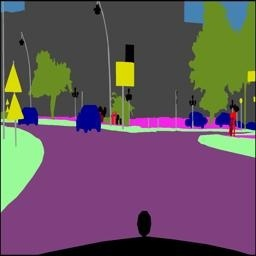

In [9]:
# display the mask associated with image
img = Image.open("/content/cityscapes/cityscapes_data/train/masks/1.jpg")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Data transformation and Data Loader

In [10]:
# Define a custom dataset class 'CityscapesDataset' that inherits from PyTorch's 'Dataset' class.
class CityscapesDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        # Create a list of file paths for images by joining the 'image_folder' path with file names ending in '.jpg' or '.png'.
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

        # Create a list of file paths for masks by joining the 'mask_folder' path with file names ending in '.jpg' or '.png'.
        self.mask_paths = [os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(('.jpg', '.png'))]

        # Store the transformation function to be applied to both images and masks.
        self.transform = transform

    # Define the length of the dataset, which is the number of images in the dataset.
    def __len__(self):
        return len(self.image_paths)

    # Define how to retrieve an item from the dataset given an index 'idx'.
    def __getitem__(self, idx):
        # Open and convert the image to RGB format.
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Open and convert the mask to grayscale.
        mask = Image.open(self.mask_paths[idx]).convert('L')

        # Apply the specified transform function to both image and mask if it exists.
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(np.array(mask)).long()  # Convert mask to LongTensor for segmentation

        # Return a tuple containing the transformed image and mask tensors.
        return image, mask

# Define a series of image transformations to be applied to both images and masks.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
# Specify the batch size for the dataloaders.
batch_size = 2
"""
Here, I first tried with batch size = 8 and 6 but "Out of Memory Error" was occuring, so I reduced it to 2.
"""

# Create a training dataset using the 'CityscapesDataset' class with specified image and mask directories and the defined transform.
train_dataset = CityscapesDataset(image_folder=train_images_dir, mask_folder=train_masks_dir, transform=transform)

# Create a training dataloader using the 'DataLoader' class, specifying the batch size and enabling shuffling of the dataset.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a validation dataset using the 'CityscapesDataset' class with specified image and mask directories and the defined transform.
val_dataset = CityscapesDataset(image_folder=val_images_dir, mask_folder=val_masks_dir, transform=transform)

# Create a validation dataloader using the 'DataLoader' class, specifying the batch size and enabling shuffling of the dataset.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
len(train_dataset), len(val_dataset)

(2975, 500)

In [13]:
EPOCHS = 3
NUM_CLASSES = 19

In [14]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 4. Segformer implementation

Link to the paper: https://arxiv.org/abs/2105.15203

SegFormer has two appealing features:

* SegFormer comprises a novel hierarchically structured Transformer encoder which outputs multiscale features. It does not need positional encoding, thereby avoiding the interpolation of positional codes which leads to decreased performance when the testing resolution differs from training.

* SegFormer avoids complex decoders. The proposed MLP decoder aggregates information from different layers, and thus combining both local attention and global attention to render powerful representations. We show that this simple and lightweight design is the key to efficient segmentation on Transformers.

In [15]:
# Define a custom layer 'LayerNorm2d' that inherits from PyTorch's 'LayerNorm'.
class LayerNorm2d(nn.LayerNorm):
    """
    Swap channel dim, apply layer norm, and swap back: see https://github.com/pytorch/pytorch/issues/71465
    """
    def forward(self, x):
        # Rearrange the input tensor to swap channel and spatial dimensions before applying layer normalization.
        x = rearrange(x, "b c h w -> b h w c")

        # Apply layer normalization using the 'super()' function to refer to the parent class.
        x = super().forward(x)

        # Rearrange the tensor back to its original shape after layer normalization.
        x = rearrange(x, "b h w c -> b c h w")

        return x

# Define a custom layer 'OverlapPatchMerging' that inherits from PyTorch's 'nn.Sequential'.
class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        # Initialize the layer as a sequential combination of a 2D convolutional layer and a custom 'LayerNorm2d'.
        super(OverlapPatchMerging, self).__init__(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=patch_size,
                stride=overlap_size,
                padding=patch_size // 2,
                bias=False
            ),
            LayerNorm2d(out_channels)
        )

In [16]:
# Define a custom module 'EfficientMultiHeadAttention' for efficient multi-head attention.
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()

        # Create a sequential module for reducing the input channels and applying layer normalization.
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )

        # Create a multi-head attention module with specified parameters.
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape

        # Reduce the input tensor's spatial dimensions using the defined reducer.
        reduced_x = self.reducer(x)

        # Attention requires tensors of shape (batch, sequence_length, channels).
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V
        x = rearrange(x, "b c h w -> b (h w) c")  # Q

        # Apply multi-head attention to the query and key tensors.
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]

        # Reshape the output back to (batch, channels, height, width).
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)

        return out

# Define a custom module 'MixMLP' for a Mix MLP block.
class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # Linear layer
            nn.Conv2d(channels, channels, kernel_size=1),

            # Depth-wise convolution
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),  # GELU activation function

            # Linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [17]:
# Define a custom module 'ResidualAdd' for adding and normalizing MHA and FFN outputs.
class ResidualAdd(nn.Module):
    """A layer that helps to add&norm MHA and FFN outputs"""
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        # Forward pass through the provided function.
        out = self.fn(x, **kwargs)

        # Add the input tensor 'x' to the output tensor and return the result.
        x = x + out
        return x

# Define a custom module 'SegFormerEncoderBlock' representing an encoder block in the SegFormer architecture.
class SegFormerEncoderBlock(nn.Sequential):
    """Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly"""
    def __init__(
        self,
        channels: int,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
        drop_path_prob: float = .0
    ):
        super(SegFormerEncoderBlock, self).__init__(
            # Apply ResidualAdd for the Multi-Head Attention (MHA) block.
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),

            # Apply ResidualAdd for the Mix MLP block.
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")
                )
            ),
        )

In [18]:
# Define a custom module 'SegFormerEncoderStage' representing an encoder stage in the SegFormer architecture.
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()

        # Apply OverlapPatchMerging to merge overlapping patches in the input.
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )

        # Create a sequential module containing multiple SegFormerEncoderBlock instances.
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )

        # Apply layer normalization to the output of the encoder stage.
        self.norm = LayerNorm2d(out_channels)


In [19]:
# Define a function 'chunks' to split an iterable into chunks of specified sizes.
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk

# Define a custom module 'SegFormerEncoder'.
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()

        # Create drop paths probabilities (one for each stage's block).
        drop_probs = [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]

        # Create a ModuleList containing SegFormerEncoderStage instances based on specified parameters.
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )

    def forward(self, x):
        features = []

        # Iterate through each stage in the encoder and collect the output features.
        for stage in self.stages:
            x = stage(x)
            features.append(x)

        return features

In [20]:
# Define a custom module 'SegFormerDecoderBlock' for a decoder block with upsampling.
class SegFormerDecoderBlock(nn.Sequential):
    """Upsample"""
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

# Define a custom module 'SegFormerDecoder' for the SegFormer decoder.
class SegFormerDecoder(nn.Module):
    """Takes a list of features and returns a list of new features with the same spatial size and channels"""
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()

        # Create a ModuleList containing SegFormerDecoderBlock instances based on specified parameters.
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )

    def forward(self, features):
        new_features = []

        # Iterate through each feature and corresponding stage in the decoder.
        for feature, stage in zip(features, self.stages):
            x = stage(feature)
            new_features.append(x)

        return new_features

In [21]:
# Define a custom module 'SegFormerSegmentationHead' for the segmentation head in the SegFormer model.
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()

        # Define a sequential module for feature fusion.
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)
        )

        # Define a convolutional layer for final prediction.
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        # Concatenate the input features along the channel dimension.
        x = torch.cat(features, dim=1)

        # Apply the feature fusion module.
        x = self.fuse(x)

        # Apply the convolutional layer for final prediction.
        x = self.predict(x)

        return x

In [22]:
# Define a custom module 'SegFormer' representing the SegFormer model.
class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):
        super(SegFormer, self).__init__()

        # Create the SegFormer encoder module.
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )

        # Create the SegFormer decoder module.
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)

        # Create the SegFormer segmentation head module.
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        # Pass the input through the SegFormer encoder.
        features = self.encoder(x)

        # Pass the encoder features through the SegFormer decoder in reverse order.
        features = self.decoder(features[::-1])

        # Perform segmentation using the SegFormer segmentation head.
        segmentation = self.head(features)

        return segmentation

In [23]:
# Create an instance of the SegFormer model with specified parameters.
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

# Forward pass through the SegFormer model with a random input tensor.
segmentation = segformer(torch.randn((1, 3, 224, 224)))

# Print the shape of the segmentation output tensor.
print(segmentation.shape)  # torch.Size([1, 2, 56, 56])

torch.Size([1, 19, 56, 56])


In [24]:
# Define a class 'EarlyStopping' for early stopping during model training.
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint when a new best is found.
        """
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        """
        Args:
            val_loss (float): Validation loss value to compare with the best loss.
            model (nn.Module): Model to be saved in the checkpoint.

        Returns:
            None
        """
        # Check if the best_loss is not initialized, or if there is a significant improvement.
        if self.best_loss is None or (self.best_loss - val_loss > self.min_delta):
            # Save the model checkpoint and update the best_loss.
            checkpoint = {
                'model': model.state_dict(),
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Increment the counter for early stopping.
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")

            # Check if the patience limit has been reached.
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [25]:
# Create an instance of the SegFormer model with specified parameters and move it to the specified device.
model = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[14, 7, 7, 7],  # Adjusted for 224x224 input size
    overlap_sizes=[7, 3, 3, 3],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=224,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
).to(device)

# Define the loss criterion (BCEWithLogitsLoss).
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer (AdamW) with specified learning rate, betas, and weight decay.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

# Define a learning rate scheduler (ReduceLROnPlateau) with specified parameters.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)

# Create an instance of the EarlyStopping class with specified patience.
stopper = EarlyStopping(patience=8)

In [26]:
def accuracy_metric(outputs, masks):
    """
    Calculates multi-class segmentation accuracy.

    Args:
        outputs (torch.Tensor): Model predictions (logits).
        masks (torch.Tensor): Ground truth segmentation masks.

    Returns:
        float: Overall pixel accuracy.
    """
    # Get the most likely class for each pixel.
    argmax_outputs = torch.argmax(outputs, dim=1)

    # Count the number of correct predictions.
    correct = (argmax_outputs == masks).float().sum().item()

    # Calculate the total number of pixels.
    total = masks.numel()

    # Calculate and return the overall pixel accuracy.
    return correct / total

In [27]:
# Training loop
for epoch in range(EPOCHS):
    # Initialize training phase metrics
    train_loss = 0.0
    train_accuracy = 0.0

    # Training phase
    model.train()  # Set the model to training mode
    for images, masks in tqdm(train_dataloader):
        # Move data to the device (GPU, if available)
        images = images.to(device)
        masks = masks.long().to(device)  # Convert masks to LongTensor

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagate the loss
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss for the epoch
        train_loss += loss.item()

        # Accumulate accuracy
        train_accuracy += accuracy_metric(outputs, masks)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        # Initialize validation phase metrics
        val_loss = 0.0
        val_accuracy = 0.0
        for images, masks in val_dataloader:
            # Move data to the device (GPU, if available)
            images = images.to(device)
            masks = masks.long().to(device)

            # Forward pass through the model
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, masks)

            # Accumulate validation loss
            val_loss += loss.item()

            # Accumulate validation accuracy
            val_accuracy += accuracy_metric(outputs, masks)

    # Print epoch metrics
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_dataloader):.4f}, Train Accuracy: {train_accuracy/len(train_dataloader):.4f}, Val Loss: {val_loss/len(val_dataloader):.4f}, Val Accuracy: {val_accuracy/len(val_dataloader):.4f}")

  0%|          | 0/1488 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 22 for tensor number 2 in the list.